# Import Libraries and set device

In [2]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF 
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Set seed for reproductability

In [3]:
seed_val = 15
random.seed(seed_val)               
np.random.seed(seed_val)           
torch.manual_seed(seed_val)      
os.environ['PYTHONHASHSEED'] = str(seed_val)
    
if torch.cuda.is_available():        
    torch.cuda.manual_seed(seed_val)
    cudnn.benchmark = True 
    cudnn.deterministic = False

function to resize image and mask to a fixed size (256x256) and convert to Tensor.

In [4]:
def img_transform(image, mask):
    # Resize image to 256x256 
    image = TF.resize(image, (256, 256))
    # Convert image to Tensor [3, 256, 256]
    image = TF.to_tensor(image)
    # IMPORTANT: Use Nearest Neighbor for masks to preserve class IDs (0, 1, 2...)
    # If you use bilinear interpolation here, your class IDs will become floats/blurry.
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)
    # Convert mask to LongTensor [256, 256] (integers required for CrossEntropyLoss)
    mask = torch.as_tensor(np.array(mask), dtype=torch.long)
    return image, mask

Define the dataset class

In [5]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, target_classes=None):
        self.root_dir = root_dir
        self.coco = COCO(ann_file)
        self.transform = transform
        
        # 1. Define Categories
        # If no specific classes are requested, use ALL categories
        if target_classes:
            self.cat_ids = self.coco.getCatIds(catNms=target_classes)
        else:
            self.cat_ids = sorted(self.coco.getCatIds()) # Sort ensures consistent ordering
            
        # 2. Create ID Mapping (Crucial for Multi-class)
        # We map COCO IDs (e.g., 1, 90) to contiguous Neural Net IDs (1, 80).
        # Background is always index 0.
        self.coco_id_to_contiguous = {coco_id: i + 1 for i, coco_id in enumerate(self.cat_ids)}
        
        # Store class names for visualization (Index 0 is 'background')
        coco_cats = self.coco.loadCats(self.cat_ids)
        self.classes = ['background'] + [c['name'] for c in coco_cats]

        # 3. Filter Images
        # Only keep images containing at least one of our target categories
        self.ids = []
        for cat_id in self.cat_ids:
            self.ids.extend(self.coco.getImgIds(catIds=[cat_id]))
        self.ids = list(set(self.ids)) # Remove duplicates

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        
        # Load image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        
        # Load Annotations
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = coco.loadAnns(ann_ids)
        
        # Create Mask (Background = 0)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        for ann in anns:
            coco_id = ann['category_id']
            
            # Use our mapping to get the contiguous ID (1-80)
            if coco_id in self.coco_id_to_contiguous:
                pixel_value = self.coco_id_to_contiguous[coco_id]
                ann_mask = coco.annToMask(ann)
                
                # Overwrite pixels (Last annotation wins in overlap)
                mask[ann_mask > 0] = pixel_value

        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

Define a function to visualize the dataset

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        # 1. ENCODER (Contracting Path)
        
        # --- Input Layer (Double Conv: Input -> 64) ---
        self.inc = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Max Pooling (Used for all downsampling steps)
        self.pool = nn.MaxPool2d(2)

        
        # --- Down 1 (Double Conv: 64 -> 128) ---
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        
        # --- Down 2 (Double Conv: 128 -> 256) ---
        self.down2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # --- Down 3 (Double Conv: 256 -> 512) ---
        self.down3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # --- Down 4 / Bottleneck (Double Conv: 512 -> 1024) ---
        factor = 2 if bilinear else 1
        self.down4 = nn.Sequential(
            nn.Conv2d(512, 1024 // factor, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024 // factor),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024 // factor, 1024 // factor, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024 // factor),
            nn.ReLU(inplace=True)
        )

        # DECODER (Expansive Path)
        
        # --- Up 1 (1024 -> 512) ---
        if bilinear:
            self.up1_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.up1_conv = nn.Sequential(
                nn.Conv2d(1024, 512 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512 // factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(512 // factor, 512 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512 // factor),
                nn.ReLU(inplace=True)
            )
        else:
            self.up1_sample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
            self.up1_conv = nn.Sequential(
                nn.Conv2d(1024, 512 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512 // factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(512 // factor, 512 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(512 // factor),
                nn.ReLU(inplace=True)
            )

        # --- Up 2 (512 -> 256) ---
        if bilinear:
            self.up2_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.up2_conv = nn.Sequential(
                nn.Conv2d(512, 256 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256 // factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(256 // factor, 256 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256 // factor),
                nn.ReLU(inplace=True)
            )
        else:
            self.up2_sample = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.up2_conv = nn.Sequential(
                nn.Conv2d(512, 256 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256 // factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(256 // factor, 256 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256 // factor),
                nn.ReLU(inplace=True)
            )

        # --- Up 3 (256 -> 128) ---
        if bilinear:
            self.up3_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.up3_conv = nn.Sequential(
                nn.Conv2d(256, 128 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128 // factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(128 // factor, 128 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128 // factor),
                nn.ReLU(inplace=True)
            )
        else:
            self.up3_sample = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.up3_conv = nn.Sequential(
                nn.Conv2d(256, 128 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128 // factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(128 // factor, 128 // factor, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(128 // factor),
                nn.ReLU(inplace=True)
            )

        # --- Up 4 (128 -> 64) ---
        if bilinear:
            self.up4_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.up4_conv = nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )
        else:
            self.up4_sample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.up4_conv = nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )

        # --- Output Layer ---
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # ==========================================
        # ENCODER FORWARD PASS
        # ==========================================
        x1 = self.inc(x)            # [Batch, 64, H, W]
        # [1, 3, 256, 256] -> [1, 64, 256, 256]
        
        x2 = self.pool(x1)          
        x2 = self.down1(x2)         # [Batch, 128, H/2, W/2]
        #[1, 128, 128, 128]
        
        x3 = self.pool(x2)
        x3 = self.down2(x3)         # [Batch, 256, H/4, W/4]
        #[1, 256, 64, 64]
        
        x4 = self.pool(x3)
        x4 = self.down3(x4)         # [Batch, 512, H/8, W/8]
        # [1, 512, 32, 32]
        
        x5 = self.pool(x4)
        x5 = self.down4(x5)         # [Batch, 1024, H/16, W/16] (Bottleneck)
        # [1, 1024, 16, 16]
        
        # ==========================================
        # DECODER FORWARD PASS
        # ==========================================
        
        # --- Up 1 ---
        x = self.up1_sample(x5)
        # Pad if dimensions don't match (handling odd sizes)
        diffY = x4.size(2) - x.size(2)
        diffX = x4.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # Concatenate and Conv
        x = torch.cat([x4, x], dim=1)
        x = self.up1_conv(x)
        
        # --- Up 2 ---
        x = self.up2_sample(x)
        diffY = x3.size(2) - x.size(2)
        diffX = x3.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x3, x], dim=1)
        x = self.up2_conv(x)
        
        # --- Up 3 ---
        x = self.up3_sample(x)
        diffY = x2.size(2) - x.size(2)
        diffX = x2.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x], dim=1)
        x = self.up3_conv(x)
        
        # --- Up 4 ---
        x = self.up4_sample(x)
        diffY = x1.size(2) - x.size(2)
        diffX = x1.size(3) - x.size(3)
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x1, x], dim=1)
        x = self.up4_conv(x)
        
        # Final Output
        logits = self.outc(x)
        return logits

In [7]:
# Hyperparameters
MOMENTUM = 0.99
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_EPOCHS = 10
NUM_WORKERS = 0         # set to 0 if model not training

In [8]:
print("Initializing Full COCO Dataset...")
data_path = './coco/train2017' 
ann_path = './coco/annotations/instances_train2017.json'

val_data_path = './coco/val2017'
val_ann_file = './coco/annotations/instances_val2017.json'

# Initialize train dataset 
train_dataset = COCOSegmentationDataset(
    root_dir=data_path, 
    ann_file=ann_path, 
    transform=img_transform,
    target_classes=None 
)

# Initialize validation dataset
val_dataset = COCOSegmentationDataset(
    root_dir=val_data_path, 
    ann_file=val_ann_file, 
    transform=img_transform,
    target_classes=None
)

NUM_CLASSES = len(train_dataset.classes)

print(f"Training on {len(train_dataset)} images with {NUM_CLASSES} classes.")
print(f"Example Classes: {train_dataset.classes[:5]}...")

# 4. Initialize Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# 5. Initialize Model with Correct Output Channels
# We change n_classes to 81
model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)

# Initialize Adam Optimizer (Lower LR for stability)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Initialize Scheduler (The missing piece!)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
# Loss Function (Ignore 255 just in case)
criterion = nn.CrossEntropyLoss(ignore_index=255)

Initializing Full COCO Dataset...
loading annotations into memory...
Done (t=16.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Training on 117266 images with 81 classes.
Example Classes: ['background', 'person', 'bicycle', 'car', 'motorcycle']...


# Training Loop

In [ ]:
print(f"Starting Training on {device} with {NUM_CLASSES} classes...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", mininterval=2.0)
    
    for i, (images, masks) in enumerate(loop):
        images = images.to(device)
        masks = masks.to(device)
        
        # --- SAFETY PATCH ---
        # If your data still has "rogue" labels > NUM_CLASSES, this fixes them on the fly
        # preventing the "device-side assert" crash.
        # We replace any invalid label with 255 (which CrossEntropyLoss ignores)
        mask_max = NUM_CLASSES - 1
        masks[masks > mask_max] = 255 
        # --------------------

        optimizer.zero_grad()
        
        # Forward & Backward
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 50 == 0:
            loop.set_postfix(loss=loss.item())
        
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation Step
    model.eval()
    val_loss = 0
    
    # We disable gradients for validation to save memory
    with torch.no_grad():
        for v_img, v_mask in val_loader:
            v_img = v_img.to(device)
            v_mask = v_mask.to(device)
            
            # Apply same Safety Patch to Validation
            v_mask[v_mask > mask_max] = 255
            
            val_out = model(v_img)
            val_loss += criterion(val_out, v_mask).item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    # step scheduler
    scheduler.step(avg_val_loss)
    
    # log
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} Completed | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")
    
    # save training checkpoint
    torch.save(model.state_dict(), f'unet_adam_epoch_{epoch+1}.pth')

print("Training Complete!")

Starting Training on cuda with 81 classes...


Epoch 1/10: 100%|████████████████████████████████████████████████████| 29317/29317 [32:59<00:00, 14.81it/s, loss=0.466]


Epoch 1 Completed | Train Loss: 1.1893 | Val Loss: 1.0257 | LR: 0.000100


Epoch 2/10: 100%|██████████████████████████████████████████████████████| 29317/29317 [30:27<00:00, 16.04it/s, loss=0.8]


Epoch 2 Completed | Train Loss: 0.9872 | Val Loss: 0.9381 | LR: 0.000100


Epoch 3/10: 100%|██████████████████████████████████████████████████████| 29317/29317 [32:10<00:00, 15.18it/s, loss=1.5]


Epoch 3 Completed | Train Loss: 0.8911 | Val Loss: 0.8751 | LR: 0.000100


Epoch 4/10: 100%|█████████████████████████████████████████████████████| 29317/29317 [36:37<00:00, 13.34it/s, loss=1.11]


Epoch 4 Completed | Train Loss: 0.8256 | Val Loss: 0.8200 | LR: 0.000100


Epoch 5/10: 100%|████████████████████████████████████████████████████| 29317/29317 [31:17<00:00, 15.62it/s, loss=0.931]


Epoch 5 Completed | Train Loss: 0.7740 | Val Loss: 0.7865 | LR: 0.000100


Epoch 6/10: 100%|████████████████████████████████████████████████████| 29317/29317 [29:44<00:00, 16.42it/s, loss=0.479]


Epoch 6 Completed | Train Loss: 0.7318 | Val Loss: 0.7661 | LR: 0.000100


Epoch 7/10: 100%|████████████████████████████████████████████████████| 29317/29317 [29:38<00:00, 16.49it/s, loss=0.548]


Epoch 7 Completed | Train Loss: 0.6954 | Val Loss: 0.7463 | LR: 0.000100


Epoch 8/10: 100%|████████████████████████████████████████████████████| 29317/29317 [29:41<00:00, 16.46it/s, loss=0.276]


Epoch 8 Completed | Train Loss: 0.6620 | Val Loss: 0.7185 | LR: 0.000100


Epoch 9/10: 100%|████████████████████████████████████████████████████| 29317/29317 [30:27<00:00, 16.04it/s, loss=0.649]


Epoch 9 Completed | Train Loss: 0.6322 | Val Loss: 0.7045 | LR: 0.000100


Epoch 10/10:   4%|██▏                                                  | 1201/29317 [01:11<27:26, 17.08it/s, loss=0.97]

Initialize weights and start training loop

Loading model from unet_adam_epoch_9.pth...
Selecting 3 random images from ./coco/test2017...


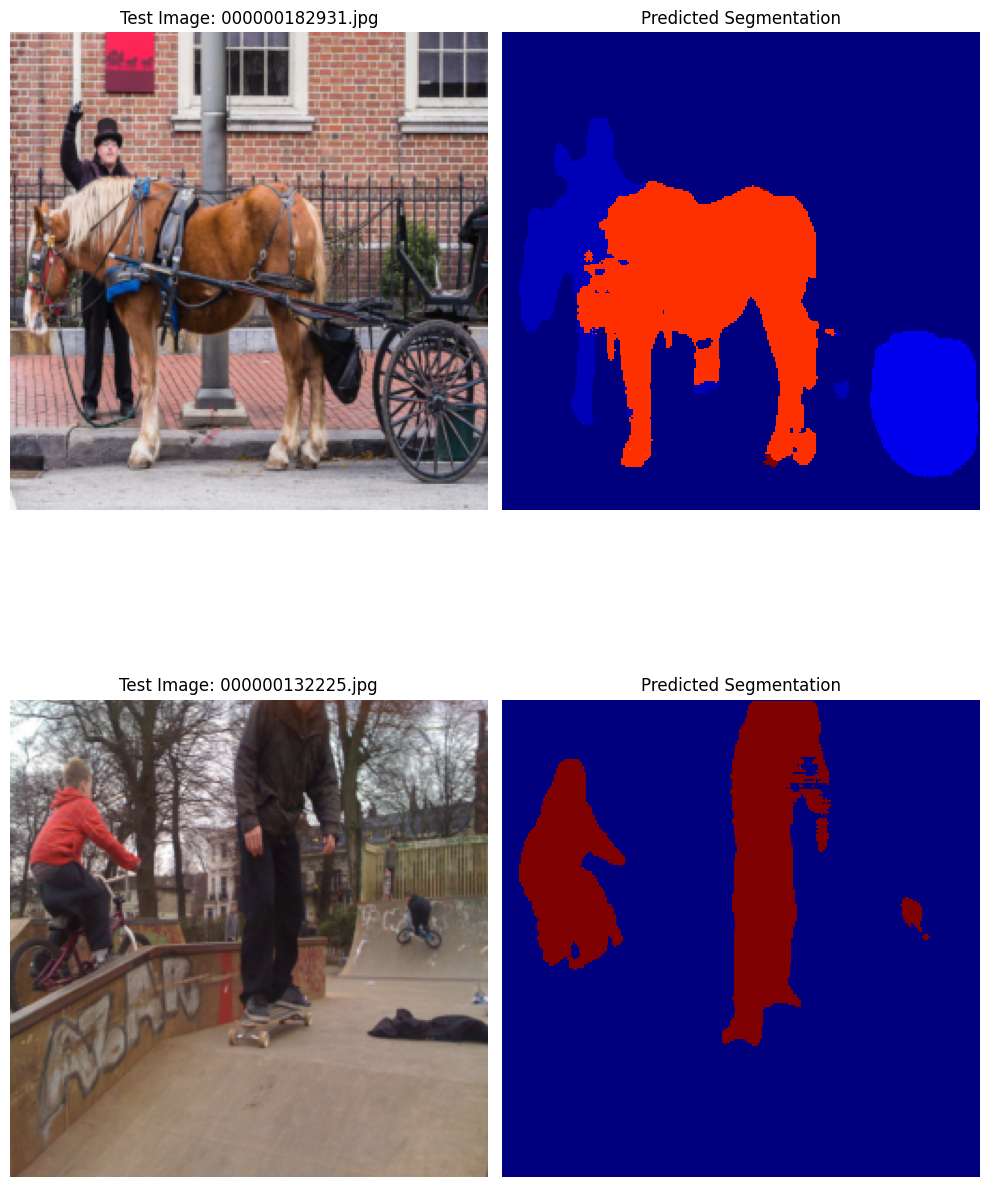

In [31]:
TEST_IMG_DIR = './coco/test2017' 
# Path to your best saved model
MODEL_PATH = 'unet_adam_epoch_9.pth' # Or 'best_model.pth' if you implemented saving the best

# 2. DEFINE HELPER FOR LOADING & PROCESSING
# =========================================
def load_random_test_images(img_dir, num_images=3):
    """
    Picks random images from the directory and prepares them for the model.
    """
    all_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
    
    if len(all_files) == 0:
        raise ValueError(f"No images found in {img_dir}")
        
    selected_files = random.sample(all_files, num_images)
    
    loaded_data = []
    
    for fname in selected_files:
        path = os.path.join(img_dir, fname)
        original_image = Image.open(path).convert('RGB')
        
        # Preprocess for Model (Resize & Tensor)
        # Note: We resize to 256x256 because U-Net expects a consistent input size 
        # that matches training.
        input_image = TF.resize(original_image, (256, 256))
        input_tensor = TF.to_tensor(input_image)
        
        loaded_data.append({
            'fname': fname,
            'original': original_image,
            'tensor': input_tensor
        })
        
    return loaded_data

# 3. LOAD MODEL
# =============
print(f"Loading model from {MODEL_PATH}...")
# Initialize the model architecture (Must match training!)
model = UNet(n_channels=3, n_classes=81).to(device)

# Load weights
# map_location ensures it loads on CPU if CUDA is not available
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval() # Important: set to eval mode!

# 4. RUN INFERENCE & VISUALIZE
# ============================
print(f"Selecting 3 random images from {TEST_IMG_DIR}...")

try:
    test_samples = load_random_test_images(TEST_IMG_DIR, num_images=2)
    
    # Create Plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 15))
    
    with torch.no_grad():
        for i, sample in enumerate(test_samples):
            # Prepare batch of size 1
            input_batch = sample['tensor'].unsqueeze(0).to(device)
            
            # Forward Pass
            logits = model(input_batch)
            
            # Get Predictions (Argmax)
            # Logits shape: [1, 2, 256, 256] -> Preds shape: [256, 256]
            preds = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
            
            # --- PLOTTING ---
            
            # Column 1: Input Image
            # We show the resized version effectively used by the network
            input_display = sample['tensor'].permute(1, 2, 0).numpy()
            axes[i][0].imshow(input_display)
            axes[i][0].set_title(f"Test Image: {sample['fname']}")
            axes[i][0].axis('off')
            
            # Column 2: Predicted Mask
            # We use a color map (like 'jet' or 'gray') to visualize the classes
            # Class 0 = Background (Purple/Black), Class 1 = Person (Yellow/White)
            axes[i][1].imshow(preds, cmap='jet', interpolation='nearest')
            axes[i][1].set_title("Predicted Segmentation")
            axes[i][1].axis('off')
            
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find directory {TEST_IMG_DIR}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")